<a href="https://colab.research.google.com/github/momowade221/Segmentation_Valeur_OM/blob/main/Transactions_OM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuration**

---



In [1]:
!pip install pyspark
!pip install  spylon-kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=916f7572ef021290b96fc0b782ec6a413f348cf1479997b3961ba0963b18dff1
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Segmentation/
path='/content/drive/MyDrive/Colab/Segmentation/0datasets'

import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.clustering import *

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
spark

Mounted at /content/drive
/content/drive/MyDrive/Colab/Segmentation


In [3]:
#!git clone https://github.com/asish012/dataanalytics.git

# **DATA PREPARATION**

## **EDA**

---



In [4]:
def printdf(df):
    return df.toPandas()

In [5]:
ofms=spark.read.csv(f'{path}/trusted_om.csv', header=True)
new_column_names = [col_name.replace("transactions.", "") for col_name in ofms.columns]
ofms= ofms.toDF(*new_column_names)
ofms.printSchema()

root
 |-- sender_msisdn: string (nullable = true)
 |-- receiver_msisdn: string (nullable = true)
 |-- receiver_user_id: string (nullable = true)
 |-- sender_user_id: string (nullable = true)
 |-- transaction_amount: string (nullable = true)
 |-- commissions_paid: string (nullable = true)
 |-- commissions_received: string (nullable = true)
 |-- commissions_others: string (nullable = true)
 |-- service_charge_received: string (nullable = true)
 |-- service_charge_paid: string (nullable = true)
 |-- taxes: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- transfer_status: string (nullable = true)
 |-- sender_pre_bal: string (nullable = true)
 |-- sender_post_bal: string (nullable = true)
 |-- receiver_pre_bal: string (nullable = true)
 |-- receiver_post_bal: string (nullable = true)
 |-- sender_acc_status: string (nullable = true)
 |-- receiver_acc_status: string (nullable = true)
 |-- error_code: string (nullable = true)
 |-- error_desc: string (nullable = true)
 

In [6]:
printdf(ofms)

,sender_msisdn,receiver_msisdn,receiver_user_id,sender_user_id,transaction_amount,commissions_paid,commissions_received,commissions_others,service_charge_received,service_charge_paid,...,validator_comments,sender_wallet_name,receiver_wallet_name,sender_user_type,receiver_user_type,filename,ingest_date,year,month,day
0,1426044,NA,NA,1426044,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20220314.csv,2022-03-15 10:25:17.224,2022,03,20220314
1,426110,NA,NA,426110,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20220326.csv,2022-03-28 07:25:15.375,2022,03,20220326
2,426110,NA,NA,426110,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20220327.csv,2022-03-28 07:25:15.375,2022,03,20220327
3,426110,NA,NA,426110,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20220327.csv,2022-03-28 07:25:15.375,2022,03,20220327
4,426110,NA,NA,426110,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20220327.csv,2022-03-28 07:25:15.375,2022,03,20220327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,1277025,NA,NA,1277025,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20230727.csv,2023-07-28 09:21:12.119244,2023,07,20230727
1586,2069904,NA,NA,2069904,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20230731.csv,2023-08-01 08:39:09.871879,2023,07,20230731
1587,2069904,NA,NA,2069904,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20230731.csv,2023-08-01 08:39:09.871879,2023,07,20230731
1588,2069904,NA,NA,2069904,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,Transactions_20230731.csv,2023-08-01 08:39:09.871879,2023,07,20230731


In [7]:
ofms.select("service_type").distinct().show()

+------------+
|service_type|
+------------+
|     CASHOUT|
|         P2P|
|    MERCHPAY|
|     BILLPAY|
|          RC|
+------------+



In [8]:
ofms.describe().show()
print(f'Le nombre de colonnes: {len(ofms.columns)}')

+-------+------------------+---------------+----------------+------------------+------------------+----------------+--------------------+------------------+-----------------------+-------------------+-----+------------+---------------+--------------+---------------+----------------+-----------------+-----------------+-------------------+----------+--------------------+----------------+-------------------+----------+-------------------+-----------+----------+----------+--------------------+-------------------+--------------------+------------------+-----------------+-----------------+------------------+------------+----------------------+--------------------+-------------------+-------------------+--------------------+--------------+-----------+-------------+--------+--------+--------------+------------+----------------+------------+--------------+------------+-------+-----------+---------------+-----------------+------------------+--------------+-------------------+---------------+----

In [9]:
# Initialize a list to store columns with all rows as NA
na_columns = []
# Check each column for all rows as NA
for column_name in ofms.columns:
    if ofms.filter(col(column_name).isNotNull()).count() != 0:
        na_columns.append(column_name)

# Print the columns with all rows as NA
print("Columns with all rows as NA:", na_columns)

Columns with all rows as NA: ['sender_msisdn', 'receiver_msisdn', 'receiver_user_id', 'sender_user_id', 'transaction_amount', 'commissions_paid', 'commissions_received', 'commissions_others', 'service_charge_received', 'service_charge_paid', 'taxes', 'service_type', 'transfer_status', 'sender_pre_bal', 'sender_post_bal', 'receiver_pre_bal', 'receiver_post_bal', 'error_code', 'error_desc', 'created_on', 'created_by', 'modified_on', 'modified_by', 'transfer_id', 'transfer_datetime', 'transfer_subtype', 'action_type', 'transaction_tag', 'is_financial', 'transfer_done', 'filename', 'ingest_date', 'year', 'month', 'day']


## **PRÉTRAITEMENT DES DONNÉES**

---



In [10]:
selected_columns = ["sender_user_id", "transaction_amount", "day"]
df = ofms.select(selected_columns).withColumnRenamed("sender_user_id", "Numero")
df.show()

+-------+------------------+--------+
| Numero|transaction_amount|     day|
+-------+------------------+--------+
|1426044|               0.0|20220314|
| 426110|               0.0|20220326|
| 426110|               0.0|20220327|
| 426110|               0.0|20220327|
| 426110|               0.0|20220327|
|1337431|               0.0|20220402|
|1337431|               0.0|20220402|
|1337431|               0.0|20220402|
|2120710|               0.0|20220406|
|2120710|               0.0|20220406|
|2120710|               0.0|20220406|
| 835398|               0.0|20220407|
| 835398|               0.0|20220407|
| 835398|               0.0|20220407|
|1688557|               0.0|20220408|
|1688557|               0.0|20220408|
|1688557|               0.0|20220408|
|1024385|               0.0|20220414|
|1024385|               0.0|20220414|
|1179724|               0.0|20220414|
+-------+------------------+--------+
only showing top 20 rows



In [11]:
min_amount = 200
max_amount = 200000

# Créer un DataFrame avec une colonne transaction_amount contenant des valeurs aléatoires
df = df.withColumn(
    "transaction_amount",
    expr(f"cast({min_amount} + (rand() * ({max_amount} - {min_amount} + 1)) as float)")
)
## Convert the date string to the desired format
# Assuming your DataFrame is named 'df' and the column is named 'day'
df = df.withColumn("date", to_date(df["day"], "yyyyMMdd")).drop("day")
# df= df.withColumn("day", date_format(to_timestamp(col("day"), "dd/MM/yyyy HH:mm:ss"), "yyyy-MM-dd HH:mm:ss"))
# df = df.withColumn("day", to_timestamp(col("day"), "yyyy-MM-dd HH:mm:ss"))

df.printSchema()
df.show()
from pyspark.sql.functions import max as pyspark_max, col, datediff, to_timestamp
from pyspark.sql.types import TimestampType

root
 |-- Numero: string (nullable = true)
 |-- transaction_amount: float (nullable = false)
 |-- date: date (nullable = true)

+-------+------------------+----------+
| Numero|transaction_amount|      date|
+-------+------------------+----------+
|1426044|         198998.84|2022-03-14|
| 426110|         199250.56|2022-03-26|
| 426110|         106145.19|2022-03-27|
| 426110|          163191.1|2022-03-27|
| 426110|         22936.021|2022-03-27|
|1337431|        117051.414|2022-04-02|
|1337431|         198170.31|2022-04-02|
|1337431|         154471.64|2022-04-02|
|2120710|         2883.0208|2022-04-06|
|2120710|         148309.94|2022-04-06|
|2120710|         128987.76|2022-04-06|
| 835398|          194402.6|2022-04-07|
| 835398|          83556.69|2022-04-07|
| 835398|          193702.9|2022-04-07|
|1688557|         122630.82|2022-04-08|
|1688557|          69108.41|2022-04-08|
|1688557|          191666.2|2022-04-08|
|1024385|          95048.25|2022-04-14|
|1024385|          85922.93|2022

In [12]:
max_date = df.agg(max("date")).collect()[0][0]
string_date=f'{max_date.year}/{max_date.month}/{max_date.day}'
latest_date = to_date(lit(string_date), 'yyyy/M/dd')
latest_date

Column<'to_date(2023/7/31, yyyy/M/dd)'>

# **MODELISATION**

---



##  **FEATURE ENGINEERING**

---



In [63]:
df_recency = df.groupBy("Numero").agg(
    datediff(latest_date, max(col("date"))).alias("Recency")
)

# Calculate Frequency (number of transactions)
df_frequency = df.groupBy("Numero").agg(
    count("*").alias("Frequency")
)

# Calculate Monetary Value (total transaction amount)
df_monetary = df.groupBy("Numero").agg(
    sum("transaction_amount").alias("Monetary")
)

# Join the recency, frequency, and monetary DataFrames
rfm = df_recency.join(df_frequency, "Numero", "inner").join(df_monetary, "Numero", "inner")
#Save to csv
rfm.toPandas().to_csv('0datasets/om_rfm_dataset.csv', index=False)
# Show the RFM DataFrame
rfm.toPandas().head(10)

,Numero,Recency,Frequency,Monetary
0,1171164,321,1,6.454382e+04
1,981442,263,3,1.812207e+05
2,1983721,174,3,1.642912e+05
3,1985285,135,3,3.725552e+05
4,1217543,229,5,4.704881e+05
5,2458293,328,4,5.347239e+05
6,1678349,309,2,1.433144e+05
7,1166787,462,2,2.652736e+05
8,1237984,347,3,3.066172e+05
9,2149585,161,17,1.869704e+06


## **MÉTHODE RFM**

In [62]:
rfm_df=rfm
# Calculer les quantiles
quantiles = rfm_df.approxQuantile(["Recency", "Frequency", "Monetary"], [0.2, 0.4, 0.6, 0.8], 0.01)

# Définir des expressions conditionnelles pour attribuer les scores
rfm_df = (rfm_df
    .withColumn("R_Score",  when(col("Recency") <= quantiles[0][0], lit(5))
                            .when(col("Recency") <= quantiles[0][1], lit(4))
                            .when(col("Recency") <= quantiles[0][2], lit(3))
                            .when(col("Recency") <= quantiles[0][3], lit(2))
                            .otherwise(lit(1)))
    .withColumn("F_Score", when(col("Frequency") >= quantiles[1][3], lit(5))
                            .when(col("Frequency") >= quantiles[1][2], lit(4))
                            .when(col("Frequency") >= quantiles[1][1], lit(3))
                            .when(col("Frequency") >= quantiles[1][0], lit(2))
                            .otherwise(lit(1)))
    .withColumn("M_Score", when(col("Monetary") >= quantiles[2][3], lit(5))
                            .when(col("Monetary") >= quantiles[2][2], lit(4))
                            .when(col("Monetary") >= quantiles[2][1], lit(3))
                            .when(col("Monetary") >= quantiles[2][0], lit(2))
                            .otherwise(lit(1)))
     .withColumn("RFM_Score", concat(col("R_Score").cast(StringType()), col("F_Score").cast(StringType()), col("M_Score").cast(StringType())))
)

# Afficher le DataFrame résultant
printdf(rfm_df)

,Numero,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1171164,321,1,6.454382e+04,2,1,1,211
1,981442,263,3,1.812207e+05,3,3,2,332
2,1983721,174,3,1.642912e+05,4,3,1,431
3,1985285,135,3,3.725552e+05,5,3,3,533
4,1217543,229,5,4.704881e+05,3,4,4,344
...,...,...,...,...,...,...,...,...
346,2136883,161,43,3.653760e+06,4,5,5,455
347,2557749,308,4,3.366753e+05,2,4,3,243
348,2375634,103,6,6.392950e+05,5,5,5,555
349,2631102,257,2,1.578056e+05,3,2,1,321


In [60]:
# segments2 = {
#    "En train de les perdre mais engagés": ["111", "112", "121", "131", "141", "151"],
#    "Sur le Point de Dormir": [
#         "331", "321", "312", "221", "213", "231", "241", "251"
#     ],
#     "Impossible de les perdre, mais en train de les perdre": [
#         "155", "154", "144", "214", "215", "115", "114", "113"
#     ],
# }

segments = {
    'Champion': ['555', '554', '544', '545', '454', '455', '445'],
    'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Fidèle potentiel': [
        '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
        '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
    ],
    'Prometteur': [
        '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
        '415', '315', '314', '313'
    ],
    'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'À risque': [
        '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
        '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
    ],
    'En sommeil': [
        '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
    ],
    'Perdu': ['111', '112', '121', '131', '141', '151'],
     'Nouveau': ['512', '511', '422', '421', '412', '411', '311'],
}


# Utiliser une expression conditionnelle pour attribuer les segments
rfm_df =  (rfm_df
    .withColumn('Segment',
        when(col('RFM_Score').isin(segments['Champion']), lit('Champion'))
        .when(col('RFM_Score').isin(segments['Fidèle']), lit('Fidèle'))
        .when(col('RFM_Score').isin(segments['Fidèle potentiel']), lit('Fidèle potentiel'))
        .when(col('RFM_Score').isin(segments['Nouveau']), lit('Nouveau'))
        .when(col('RFM_Score').isin(segments['Prometteur']), lit('Prometteur'))
        .when(col('RFM_Score').isin(segments['À surveiller']), lit('À surveiller'))
        # .when(col('RFM_Score').isin(segments['À réactiver']), lit('À réactiver'))
        .when(col('RFM_Score').isin(segments['À risque']), lit('À risque'))
        # .when(col('RFM_Score').isin(segments['A ne pas perdre']), lit('A ne pas perdre'))
        .when(col('RFM_Score').isin(segments['En sommeil']), lit('En sommeil'))
        .when(col('RFM_Score').isin(segments['Perdu']), lit('Perdu'))
        .otherwise(lit('Autre'))
    )
)


printdf(rfm_df)


,Numero,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,1171164,321,1,6.454382e+04,2,1,1,211,En sommeil
1,981442,263,3,1.812207e+05,3,3,2,332,En sommeil
2,1983721,174,3,1.642912e+05,4,3,1,431,Fidèle potentiel
3,1985285,135,3,3.725552e+05,5,3,3,533,Fidèle potentiel
4,1217543,229,5,4.704881e+05,3,4,4,344,Fidèle
...,...,...,...,...,...,...,...,...,...
346,2136883,161,43,3.653760e+06,4,5,5,455,Champion
347,2557749,308,4,3.366753e+05,2,4,3,243,À risque
348,2375634,103,6,6.392950e+05,5,5,5,555,Champion
349,2631102,257,2,1.578056e+05,3,2,1,321,Autre


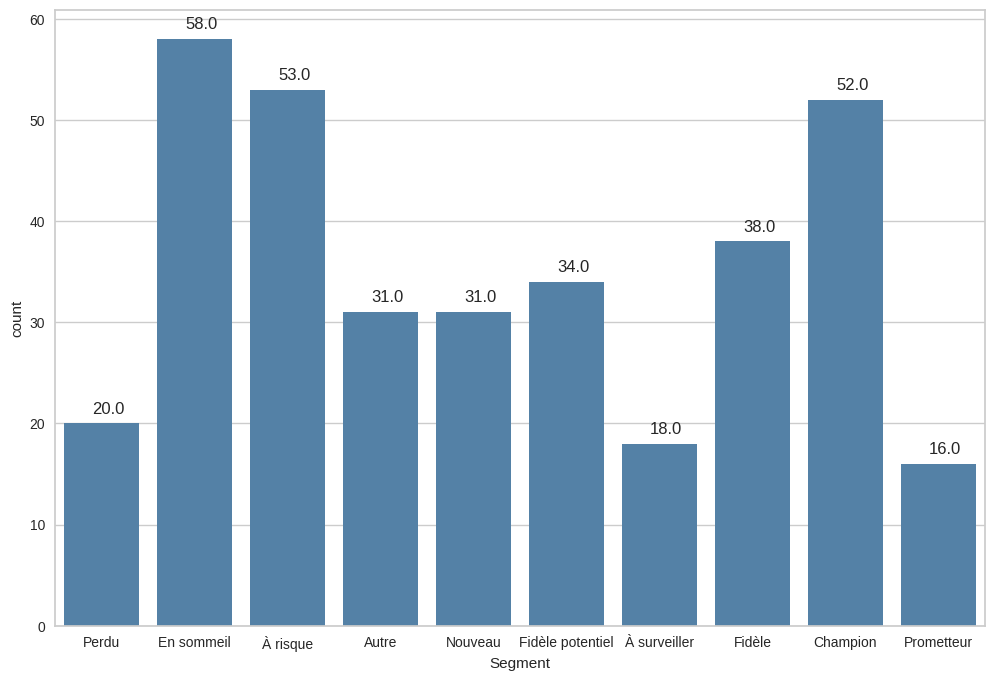

In [49]:
df_rfm_segment = rfm_df.toPandas().sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# sns.histplot(df_rfm_fidelite["Fidelite"], color='steelblue', shrink=.8)
sns.countplot(x="Segment", data=df_rfm_segment, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [45]:
def customer_segment(num):
  return rfm_df.select("Numero","Segment").where(col("Numero")==num).collect()[0][1]

customer_group(2375634)

'Champion'

## **KMEANS**

---





### Nombre de clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

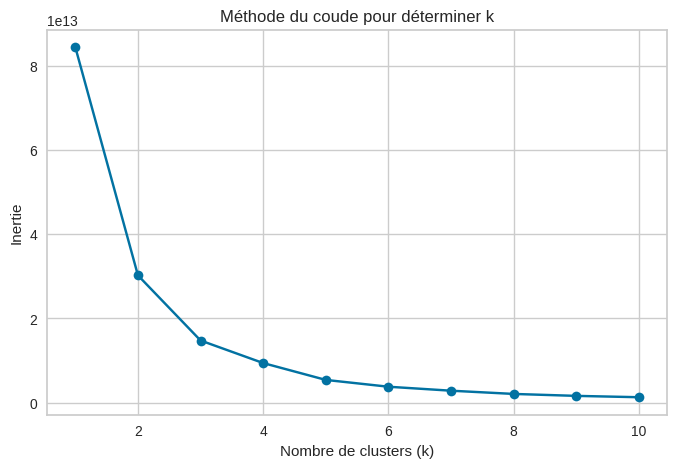

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Sélectionner les colonnes RFM pour l'analyse
pd_rfm=rfm.toPandas()
rfm_features = pd_rfm[['Recency', 'Frequency', 'Monetary']]

# Liste des valeurs de k à tester
k_values = range(1, 11)

# Liste pour stocker les valeurs d'inertie (somme des carrés des distances)
inertia_values = []

# Calculer l'inertie pour chaque valeur de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_features)
    inertia_values.append(kmeans.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

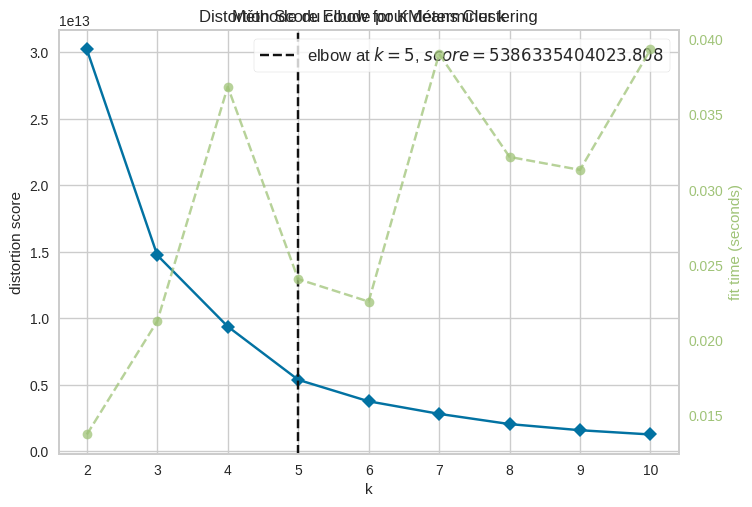

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
# Sélectionner les colonnes RFM pour l'analyse
pd_rfm=rfm.toPandas()
rfm_features = pd_rfm[['Recency', 'Frequency', 'Monetary']]

# Liste des valeurs de k à tester
k_values = range(1, 11)

# Liste pour stocker les valeurs d'inertie (somme des carrés des distances)
inertia_values = []

# Calculer l'inertie pour chaque valeur de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_features)
    inertia_values.append(kmeans.inertia_)

# k is range of number of clusters.
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(n_clusters=k_values, max_iter=300, random_state=42), k_values=(1,10), timings= True)
visualizer.fit(rfm_features)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.grid(True)
visualizer.show()

### Modèle

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


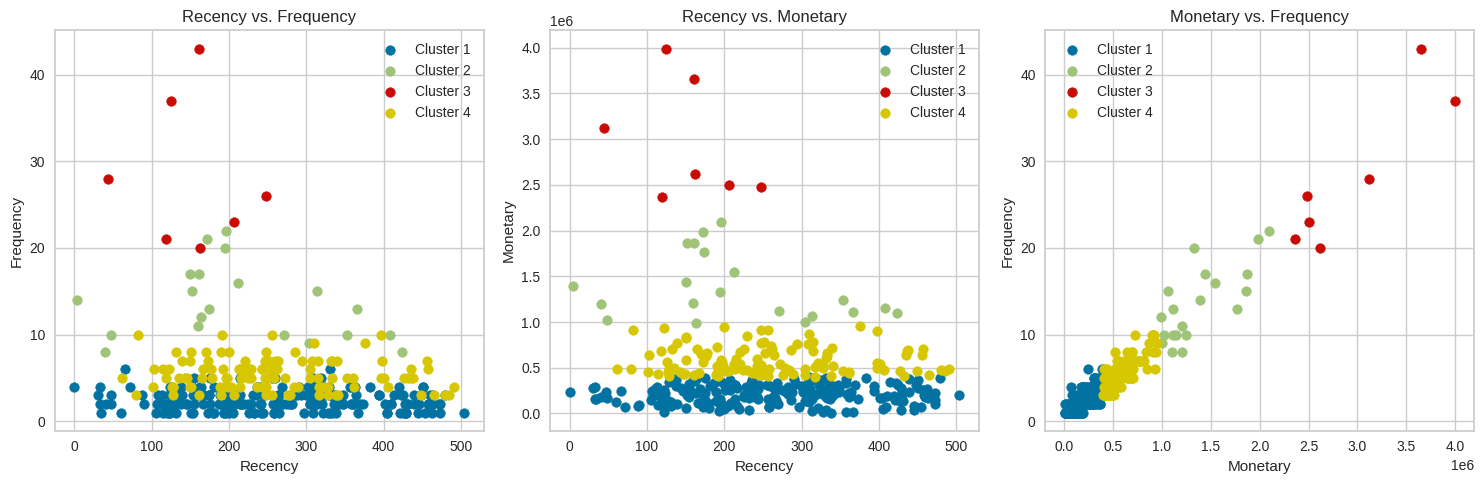

In [64]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select the features for K-Means clustering
X = pd_rfm[["Recency", "Frequency", "Monetary"]]

# Define the number of clusters
n_clusters = 4

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
pd_rfm["cluster"] = kmeans.fit_predict(X)

# Now rfm_df contains a new column "cluster" with cluster labels
# You can access the cluster labels and further analyze the results

# Create a color map for the clusters
colors = ['b', 'g', 'r', 'y']  # You can add more colors if needed

# Create a figure with three subplots in one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1
for cluster, color in zip(range(n_clusters), colors):
    axes[0].scatter(
        pd_rfm[pd_rfm["cluster"] == cluster]["Recency"],
        pd_rfm[pd_rfm["cluster"] == cluster]["Frequency"],
        c=color,
        label=f'Cluster {cluster + 1}'
    )
axes[0].set_xlabel("Recency")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Recency vs. Frequency")
axes[0].legend()

# Subplot 2
for cluster, color in zip(range(n_clusters), colors):
    axes[1].scatter(
        pd_rfm[pd_rfm["cluster"] == cluster]["Recency"],
        pd_rfm[pd_rfm["cluster"] == cluster]["Monetary"],
        c=color,
        label=f'Cluster {cluster + 1}'
    )
axes[1].set_xlabel("Recency")
axes[1].set_ylabel("Monetary")
axes[1].set_title("Recency vs. Monetary")
axes[1].legend()

# Subplot 3
for cluster, color in zip(range(n_clusters), colors):
    axes[2].scatter(
        pd_rfm[pd_rfm["cluster"] == cluster]["Monetary"],
        pd_rfm[pd_rfm["cluster"] == cluster]["Frequency"],
        c=color,
        label=f'Cluster {cluster + 1}'
    )
axes[2].set_xlabel("Monetary")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Monetary vs. Frequency")
axes[2].legend()

# Adjust the layout
plt.tight_layout()

# Display the subplots
plt.show()


### Profilage des segments

In [27]:
# Créez un DataFrame pour les clients spécifiques
specific_clients = pd.DataFrame({
    "Recency": [291.666667, 20, 30],  # Exemple : valeurs de récence pour les clients spécifiques
    "Frequency": [8.866667, 10, 3],  # Exemple : valeurs de fréquence pour les clients spécifiques
    "Monetary": [9.328025e+05, 500, 800]  # Exemple : valeurs de valeur monétaire pour les clients spécifiques
})

# Utilisez le modèle K-Means préalablement ajusté pour prédire les clusters pour les clients spécifiques
specific_clients["predicted_cluster"] = kmeans.predict(specific_clients)
type(specific_clients)
# Créez une fonction pour mapper les clusters prédits aux segments de clients
def assign_segment(cluster):
    if cluster == 0:
        return "Meilleurs clients"
    elif cluster == 1:
        return "Dépensiers"
    elif cluster == 2:
        return "Clients fidèles"

# Appliquez la fonction pour obtenir les segments de clients prédits
specific_clients["predicted_segment"] = specific_clients["predicted_cluster"].apply(assign_segment)

# Affichez les prédictions pour les clients spécifiques
print(specific_clients)


      Recency  Frequency  Monetary  predicted_cluster  predicted_segment
0  291.666667   8.866667  932802.5                  3               None
1   20.000000  10.000000     500.0                  0  Meilleurs clients
2   30.000000   3.000000     800.0                  0  Meilleurs clients


## **CLT**

---



## **Hierarchical Clustering**

---



## **DBSCAN**

# **TESTS**